In [14]:
# Import packages
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# User Segmentation Analysis

In [15]:
# Load processed data
entries_df = pd.read_csv('processed_contest_entries.csv')

In [16]:
# Clean the EntryName column to remove fractions
entries_df['EntryName'] = entries_df['EntryName'].str.replace(r'\s*\(\d+/\d+\)', '', regex=True)

In [22]:
# Normalize the Rank by the total number of entries in each contest
entries_df['NormalizedRank'] = entries_df['Rank'] / entries_df.groupby('Contest')['Rank'].transform('max')

In [ ]:
# Create user behavioral features
user_features = entries_df.groupby('EntryName').agg({
    'EntryId': 'count',  # Activity level
    'EntryFee': ['mean', 'max', 'sum'],  # Spending behavior
    'Points': ['mean', 'std'],  # Performance and consistency
    'NormalizedRank': ['mean', 'min'],  # Success rate
}).reset_index()

# Fill missing values in the std column with 0
user_features.loc[:, ('Points', 'std')] = user_features['Points']['std'].fillna(0)

# Flatten multi-level columns
user_features.columns = ['_'.join(col).strip('_') for col in user_features.columns.values]

# Convert best_rank_percentile to a percentage
user_features['NormalizedRank_min'] = user_features['NormalizedRank_min'] * 100

In [37]:
# Add derived features
user_features['spend_to_activity_ratio'] = user_features['EntryFee_sum'] / user_features['EntryId_count']
user_features['performance_consistency'] = user_features['Points_std'] / user_features['Points_mean']
user_features['best_rank_percentile'] = user_features['NormalizedRank_min'] / entries_df['NormalizedRank'].max()

# Fill missing values in the performance consistency column with 0
user_features.loc[:, 'performance_consistency'] = user_features['performance_consistency'].fillna(0)

In [38]:
# Round every column to the nearest 2 decimal places
user_features = user_features.round(2)

### Apply clustering to identify user segments

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [40]:
# Select features for clustering
clustering_features = [
    'EntryId_count', 'EntryFee_mean', 'EntryFee_max', 
    'Points_mean', 'NormalizedRank_mean', 'spend_to_activity_ratio', 
    'performance_consistency', 'best_rank_percentile'
]

In [41]:
# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_features[clustering_features])

In [42]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
user_features['Segment'] = kmeans.fit_predict(scaled_features)

In [68]:
# Analyze segment characteristics
segment_profiles = user_features.groupby('Segment').agg({
    'EntryName': 'count',  # Segment size
    'EntryId_count': 'mean',  # Activity level
    'EntryFee_mean': 'mean',  # Average spend per entry
    'EntryFee_sum': 'mean',  # Total spend
    'Points_mean': 'mean',  # Performance
    'NormalizedRank_mean': 'mean',  # Average rank
    'best_rank_percentile': 'mean',  # Best performance
}).reset_index()

In [75]:
# Name the segments based on their characteristics
def name_segment(row):
    if row['EntryId_count'] > 10 and row['EntryFee_mean'] > 20:
        return "High-Value Regulars"
    elif row['EntryId_count'] > 10 and row['EntryFee_mean'] <= 20:
        return "Volume Players"
    elif row['EntryId_count'] <= 10 and row['NormalizedRank_mean'] < 0.4:
        return "Skilled Occasionals"
    else:
        return "Casual Experimenters"
    
segment_profiles['SegmentName'] = segment_profiles.apply(name_segment, axis=1)

In [76]:
# Calculate segment value
segment_profiles['TotalSegmentValue'] = segment_profiles['EntryName'] * segment_profiles['EntryFee_sum']
segment_profiles['SegmentValuePct'] = segment_profiles['TotalSegmentValue'] / segment_profiles['TotalSegmentValue'].sum() * 100

/var/folders/qb/6_h8jj053vx4xpnglc63kx6r0000gn/T/ipykernel_78867/2306136465.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


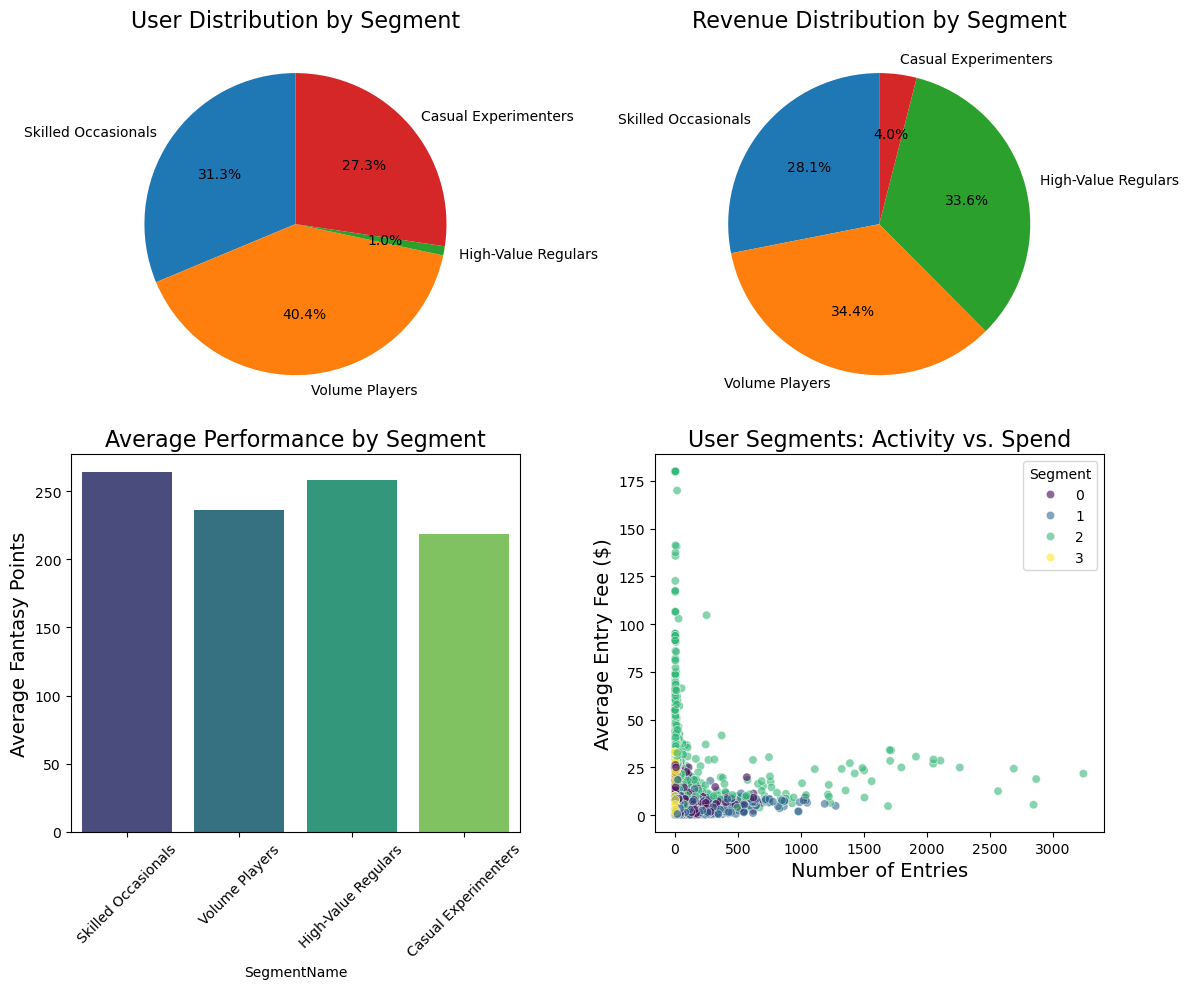

In [79]:
# Visualize segments
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.pie(segment_profiles['EntryName'], 
        labels=segment_profiles['SegmentName'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('User Distribution by Segment', fontsize=16)

plt.subplot(2, 2, 2)
plt.pie(segment_profiles['TotalSegmentValue'], 
        labels=segment_profiles['SegmentName'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Revenue Distribution by Segment', fontsize=16)

plt.subplot(2, 2, 3)
sns.barplot(
    data=segment_profiles,
    x='SegmentName',
    y='Points_mean',
    palette='viridis'
)
plt.title('Average Performance by Segment', fontsize=16)
plt.ylabel('Average Fantasy Points', fontsize=14)
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.scatterplot(
    data=user_features, 
    x='EntryId_count', 
    y='EntryFee_mean',
    hue='Segment',
    alpha=0.6,
    palette='viridis'
)
plt.title('User Segments: Activity vs. Spend', fontsize=16)
plt.xlabel('Number of Entries', fontsize=14)
plt.ylabel('Average Entry Fee ($)', fontsize=14)

plt.tight_layout()
plt.savefig('user_segmentation.png', dpi=300)